# XGBoost
- Creating dataset 
    - Frequency and severity response 
    - Groups to represent policy number 
    - Extra (invisible) features to represent cytora external features for building lift model 
- Build xgb model 
    - Evaluate on mse, loglikelihood, feature importance with graphviz 
- Cross validated predicitions 
    - Evaluate on same metrics 
- Build lift model 

# Imports

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sc

from sklearn.cross_validation import cross_val_predict as cvp
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold

from sklearn.metrics import mean_squared_error
import graphviz

/home/wout/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Dataset

Generating dataset 

Features 
- building declared value gamma 
- 

Response 
- Increasing error dependent of mu 
- Poisson frequency 
- Gamma severity 

In [2]:
n = 100000
# with 1000000 it takes very long: [20150]	eval-poisson-nloglik:0.182184	train-poisson-nloglik:0.166313


def trade(x):
    if x == 1:
        return 'restaurant'
    if x == 2:
        return 'factory'
    return 'other'

df = pd.DataFrame({
    'bdv': sc.random.gamma(2,6000000,n),
    'years_old': sc.random.randint(0,20,n),
    'building_height': sc.random.gamma(1,20,n),
    'trade': pd.Series(sc.random.randint(0,3,n)).apply(trade) 
})

df[list(pd.get_dummies(df['trade']))] = pd.get_dummies(df['trade'])
df.drop('trade', axis=1,inplace=True)

df['policy_number'] = sc.random.randint(0, np.round(n/5), n)


df['expected_claim_count'] = 0.1
df['expected_claim_count'] = df['expected_claim_count'] * (df['bdv'] / 6000000)**3
df['expected_claim_count'] = 0.7 * df['expected_claim_count'] * (df['building_height'] / 80)**2
df['expected_claim_count'] = df['expected_claim_count'] + df['expected_claim_count'] * df['factory'] * 4
df['expected_claim_count'] = df['expected_claim_count'] + df['expected_claim_count'] * df['restaurant'] * 1.2
df['expected_claim_count'] = df['expected_claim_count'] * (1 + df['years_old'] / 10)



# df['expected_claim_amount'] = 0.2
# df['expected_claim_amount'] = df['expected_claim_amount'] * (df['building_height'] / 80)
# df['expected_claim_amount'] = df['expected_claim_amount'] + df['expected_claim_count'] * df['factory'] * 100
# df['expected_claim_amount'] = df['expected_claim_amount'] + df['expected_claim_count'] * df['restaurant'] * 1.4
# df['expected_claim_amount'] = df['expected_claim_amount'] * (1 + df['years_old'] / 20)


# print('amount>bdv:', sum(df['expected_claim_amount'] > 1) / len(df))





df['claim_count'] = df['expected_claim_count'].apply(lambda x: sc.random.poisson(x))
# df['incurred'] = df['expected_claim_amount'].apply(lambda x: sc.random.gamma(x))


# print('incurred>bdv:', sum(df['incurred'] > 1) / len(df))


# df['incurred'] = df['expected_claim_amount'].clip(0,1)




display(df.head())

# display(df[['expected_claim_amount']].describe())

# df['expected_claim_amount'].plot('hist', bins=50)

,bdv,building_height,years_old,factory,other,restaurant,policy_number,expected_claim_count,claim_count
0,6.296961e+06,6.644808,0,0,1,0,12064,0.000558,0
1,1.671498e+07,7.743655,6,1,0,0,106,0.113439,1
2,4.977065e+06,22.414727,6,1,0,0,17753,0.025092,0
3,7.227026e+06,7.736910,14,1,0,0,14972,0.013730,0
4,1.144710e+07,33.959818,3,0,0,1,14067,0.250523,0


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bdv,100000.0,1.198925e+07,8.470553e+06,2.712660e+04,5.781876e+06,1.006788e+07,1.613585e+07,1.075599e+08
building_height,100000.0,1.993280e+01,1.997459e+01,2.582532e-04,5.710857e+00,1.378784e+01,2.765624e+01,2.693264e+02
years_old,100000.0,9.489280e+00,5.778311e+00,0.000000e+00,4.000000e+00,9.000000e+00,1.500000e+01,1.900000e+01
factory,100000.0,3.342300e-01,4.717229e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
other,100000.0,3.356300e-01,4.722126e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
restaurant,100000.0,3.301400e-01,4.702657e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
policy_number,100000.0,9.983802e+03,5.775938e+03,0.000000e+00,4.969000e+03,9.950000e+03,1.498300e+04,1.999900e+04
expected_claim_count,100000.0,1.115340e+00,8.262140e+00,1.221415e-12,2.398230e-03,2.887462e-02,2.472339e-01,6.290547e+02
claim_count,100000.0,1.117820e+00,8.337708e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.330000e+02


# Dataprep

In [4]:
features = [
    'bdv',
    'building_height',
    'years_old',
    'factory',
    'other',
    'restaurant',
]

In [5]:
group_kfold = sk.model_selection.GroupKFold(n_splits=5)

In [6]:
X = df[features]#.values
y = df['claim_count']#.values
groups = df['policy_number']#.values


group_kfold.get_n_splits(
    X, 
    y,
    groups
)

5

In [7]:
for train_index, test_index in group_kfold.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [8]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(80000, 6)
(20000, 6)
(80000,)
(20000,)


# XGBoost

In [9]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [10]:
param = {
    'max_depth': 2, 
    'eta': 0.2, 
    'silent': True, 
    "objective": "count:poisson",
    "eval_metric": "poisson-nloglik",
    'verbose_eval': 10,
#     'early_stopping_rounds': 50
}

early_stopping_rounds = 50
num_round = 10000

In [11]:
evallist = [(dtrain, 'train') , (dtest, 'eval')]
bst = xgb.train(
    param, 
    dtrain, 
    num_round, 
    evallist, 
    early_stopping_rounds=early_stopping_rounds, 
    verbose_eval=50
)

[0]	train-poisson-nloglik:2.26907e+09	eval-poisson-nloglik:2.36772e+09
Multiple eval metrics have been passed: 'eval-poisson-nloglik' will be used for early stopping.

Will train until eval-poisson-nloglik hasn't improved in 50 rounds.
[50]	train-poisson-nloglik:1.58196e+07	eval-poisson-nloglik:1.65074e+07
[100]	train-poisson-nloglik:110291	eval-poisson-nloglik:115086
[150]	train-poisson-nloglik:768.899	eval-poisson-nloglik:802.371
[200]	train-poisson-nloglik:5.81109	eval-poisson-nloglik:6.04809
[250]	train-poisson-nloglik:0.790669	eval-poisson-nloglik:0.765859
[300]	train-poisson-nloglik:0.688246	eval-poisson-nloglik:0.664167
[350]	train-poisson-nloglik:0.621169	eval-poisson-nloglik:0.599549
[400]	train-poisson-nloglik:0.588293	eval-poisson-nloglik:0.570431
[450]	train-poisson-nloglik:0.556968	eval-poisson-nloglik:0.542077
[500]	train-poisson-nloglik:0.534888	eval-poisson-nloglik:0.523523
[550]	train-poisson-nloglik:0.519755	eval-poisson-nloglik:0.511984
[600]	train-poisson-nloglik:0.

In [12]:
pred = bst.predict(dtest)

count    2.000000e+04
mean     1.102054e+00
std      8.303184e+00
min      7.253622e-07
25%      2.110188e-03
50%      2.862757e-02
75%      2.535395e-01
max      4.129277e+02
dtype: float64

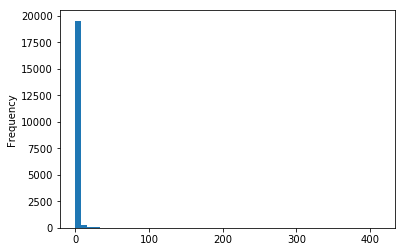

In [13]:
pd.Series(pred).plot('hist', bins=50)
pd.Series(pred).describe()

In [14]:
mean_squared_error(pred, y_test)

3.5867102546496872

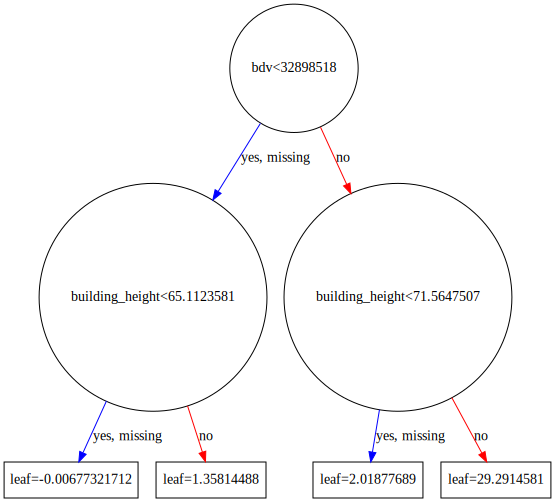

In [15]:
xgb.to_graphviz(bst, num_trees=0)

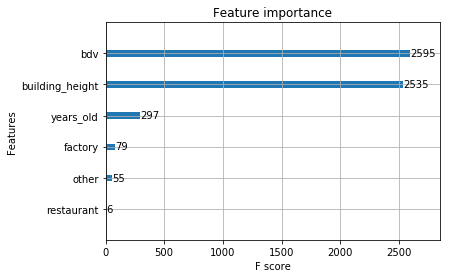

In [16]:
xgb.plot_importance(bst)

# Cross validated predictions 

Take-aways:
- Pete built cv predictions because this is not supported by cv functionality in xgboost api?
    - only output is a pandas dataframe with cross validated performance 
    - doesn't create model instance with predict option 
- Pete just copied it and added the model_cv through CVPack and model_cv
- This differs to the default xgboost.cv function in the following key ways:
    - cv fold design matrices can be pre-computed to avoid repeating this time
      consuming step every time cv() is called
    - the CVPack objects are returned (which include the boosters for each
      fold), allowing the cross-validated models to be used for prediction
    - cv fold creation functionality dropped (as they should be pre-computed)
  

In [25]:
xgb.cv(params=param, dtrain=dtrain, num_boost_round=2000, early_stopping_rounds=10, verbose_eval=50)

[0]	train-poisson-nloglik:3.74603e+07+2.64037e+07	test-poisson-nloglik:4.28139e+07+3.01937e+07
[50]	train-poisson-nloglik:261166+184082	test-poisson-nloglik:398696+313246
[100]	train-poisson-nloglik:1820.39+1283.24	test-poisson-nloglik:2779.34+2183.62
[150]	train-poisson-nloglik:13.0037+8.66658	test-poisson-nloglik:19.701+15.0637
[200]	train-poisson-nloglik:0.764747+0.147234	test-poisson-nloglik:0.95053+0.368252
[250]	train-poisson-nloglik:0.65426+0.116838	test-poisson-nloglik:0.790589+0.280088
[300]	train-poisson-nloglik:0.589547+0.070015	test-poisson-nloglik:0.687559+0.180865
[350]	train-poisson-nloglik:0.550226+0.0414191	test-poisson-nloglik:0.629144+0.125205
[400]	train-poisson-nloglik:0.526795+0.0267183	test-poisson-nloglik:0.592965+0.0903845
[450]	train-poisson-nloglik:0.514233+0.0230298	test-poisson-nloglik:0.576708+0.081113
[500]	train-poisson-nloglik:0.506068+0.0199514	test-poisson-nloglik:0.566862+0.075905
[550]	train-poisson-nloglik:0.498288+0.0171224	test-poisson-nloglik:0.

,test-poisson-nloglik-mean,test-poisson-nloglik-std,train-poisson-nloglik-mean,train-poisson-nloglik-std
0,4.281394e+07,3.019373e+07,3.746034e+07,2.640373e+07
1,4.858025e+07,3.700107e+07,3.391865e+07,2.390739e+07
2,4.596821e+07,3.576466e+07,3.071182e+07,2.164707e+07
3,4.162216e+07,3.238330e+07,2.780817e+07,1.960045e+07
4,3.768699e+07,2.932162e+07,2.517905e+07,1.774733e+07
5,3.412388e+07,2.654941e+07,2.279850e+07,1.606941e+07
6,3.089765e+07,2.403930e+07,2.064302e+07,1.455013e+07
7,2.797643e+07,2.176651e+07,1.869133e+07,1.317449e+07
8,2.564400e+07,2.007313e+07,1.692416e+07,1.192891e+07
9,2.321949e+07,1.817532e+07,1.532407e+07,1.080109e+07


In [26]:
xgb_cv = xgb.cv(params=param, dtrain=dtrain, num_boost_round=2000, early_stopping_rounds=10, verbose_eval=50)

[0]	train-poisson-nloglik:3.74603e+07+2.64037e+07	test-poisson-nloglik:4.28139e+07+3.01937e+07
[50]	train-poisson-nloglik:261166+184082	test-poisson-nloglik:398696+313246
[100]	train-poisson-nloglik:1820.39+1283.24	test-poisson-nloglik:2779.34+2183.62
[150]	train-poisson-nloglik:13.0037+8.66658	test-poisson-nloglik:19.701+15.0637
[200]	train-poisson-nloglik:0.764747+0.147234	test-poisson-nloglik:0.95053+0.368252
[250]	train-poisson-nloglik:0.65426+0.116838	test-poisson-nloglik:0.790589+0.280088
[300]	train-poisson-nloglik:0.589547+0.070015	test-poisson-nloglik:0.687559+0.180865
[350]	train-poisson-nloglik:0.550226+0.0414191	test-poisson-nloglik:0.629144+0.125205
[400]	train-poisson-nloglik:0.526795+0.0267183	test-poisson-nloglik:0.592965+0.0903845
[450]	train-poisson-nloglik:0.514233+0.0230298	test-poisson-nloglik:0.576708+0.081113
[500]	train-poisson-nloglik:0.506068+0.0199514	test-poisson-nloglik:0.566862+0.075905
[550]	train-poisson-nloglik:0.498288+0.0171224	test-poisson-nloglik:0.

In [27]:
type(xgb_cv)

pandas.core.frame.DataFrame

In [17]:
# X = datasets.load_iris().data[:, :2]
# y = datasets.load_iris().target
# xgb_model = xgb.XGBRegressor()
# y_pred = cvp(xgb_model, X, y, cv=3, n_jobs = 1)
# y_pred

In [18]:
bst2 = xgb.XGBRegressor(
    eta = 0.2,
    eval_metric = 'poisson-nloglik',
    max_depth = 2,
    objective = 'count:poisson',
    silent = True,
    verbose_eval = 10,
    early_stopping_rounds=50,
    num_round = 10000
)

In [19]:
y_pred = cvp(bst2, X, y, cv=5)
y_pred

array([ 0.00691906,  0.23277925,  0.08715432, ...,  0.17767455,
        0.22702384,  0.52751034], dtype=float32)

In [20]:
mean_squared_error(y, y_pred)

323080807398694.56

#### TODO why is this mse so much bigger?


### Appendix

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [28]:
# generate regression dataset
# X, y = make_regression(n_samples=100, n_features=2, noise=0.1, random_state=1)
scalarX, scalarY = MinMaxScaler(), MinMaxScaler()
scalarX.fit(X_train)
scalarY.fit(y_train.reshape(len(y_train),1))
X_keras = scalarX.transform(X_train)
y_keras = scalarY.transform(y_train.reshape(len(y_train),1))
# define and fit the final model
model = Sequential()
model.add(Dense(4, input_dim=7, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(X_keras, y_keras, epochs=1000, verbose=0)

/home/wout/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """
/home/wout/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/sklearn/utils/validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/wout/.local/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


KeyboardInterrupt: 

In [ ]:
# new instances where we do not know the answer
X_keras_test = scalarX.transform(X_test)
# make a prediction
y_pred_keras = model.predict(X_keras_test)# show the inputs and predicted outputs

mean_squared_error(np.hstack(y_pred_keras), y_test)

In [ ]:
keras_comparison = pd.DataFrame({
    'y_test': y_test,
    'y_pred_keras': np.hstack(y_pred_keras)
})

keras_comparison.groupby('y_test').agg({
    'y_pred_keras': [np.min, np.mean, np.median, np.max]
})

In [ ]:
def cv_in_xgboost_package(params, dtrain, num_boost_round=10, nfold=3, stratified=False, folds=None,
       metrics=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None,
       fpreproc=None, as_pandas=True, verbose_eval=None, show_stdv=True,
       seed=0, callbacks=None, shuffle=True):
    # pylint: disable = invalid-name
    """Cross-validation with given parameters.

    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round : int
        Number of boosting iterations.
    nfold : int
        Number of folds in CV.
    stratified : bool
        Perform stratified sampling.
    folds : a KFold or StratifiedKFold instance or list of fold indices
        Sklearn KFolds or StratifiedKFolds object.
        Alternatively may explicitly pass sample indices for each fold.
        For `n` folds, `folds` should be a length `n` list of tuples.
        Each tuple is `(in,out)` where `in` is a list of indices to be used
        as the training samples for the `n`th fold and `out` is a list of
        indices to be used as the testing samples for the `n`th fold.
    metrics : string or list of strings
        Evaluation metrics to be watched in CV.
    obj : function
        Custom objective function.
    feval : function
        Custom evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. CV error needs to decrease at least
        every <early_stopping_rounds> round(s) to continue.
        Last entry in evaluation history is the one from best iteration.
    fpreproc : function
        Preprocessing function that takes (dtrain, dtest, param) and returns
        transformed versions of those.
    as_pandas : bool, default True
        Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    verbose_eval : bool, int, or None, default None
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    show_stdv : bool, default True
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    seed : int
        Seed used to generate the folds (passed to numpy.random.seed).
    callbacks : list of callback functions
        List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using xgb.callback module.
        Example: [xgb.callback.reset_learning_rate(custom_rates)]
     shuffle : bool
        Shuffle data before creating folds.

    Returns
    -------
    evaluation history : list(string)
    """
    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')

    if isinstance(metrics, str):
        metrics = [metrics]

    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())

    if len(metrics) == 0 and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]

    params.pop("eval_metric", None)

    results = {}
    cvfolds = mknfold(dtrain, nfold, params, seed, metrics, fpreproc,
                      stratified, folds, shuffle)

    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))

    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    else:
        if isinstance(verbose_eval, int):
            callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))

    callbacks_before_iter = [
        cb for cb in callbacks if cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if not cb.__dict__.get('before_iteration', False)]

    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds])

        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results.keys():
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results


def cv_pete(D_cv_in, D_cv_out, params, num_boost_round, early_stopping_rounds=None,
       metrics=None, obj=None, feval=None, maximize=False, callbacks=None,
       verbose_eval=False, show_stdv=False, as_pandas=True):
    """
    Custom xgboost cross-validation function which uses pre-computed in/out of
    fold design matrices and returns the fold-wise models so that they can be used
    for prediction and further analysis.
    The function is based on the default cv() in:
    https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/training.py
    This differs to the default xgboost.cv function in the following key ways:
        - cv fold design matrices can be pre-computed to avoid repeating this time
          consuming step every time cv() is called
        - the CVPack objects are returned (which include the boosters for each
          fold), allowing the cross-validated models to be used for prediction
        - cv fold creation functionality dropped (as they should be pre-computed)
    Parameters different to default function:
    :param D_cv_in: list of 'in-fold' design matrices, to be used for training
    :type D_cv_in: list[DMatrix]
    :param D_cv_out: list of 'out-of-fold' design matrices, to be used for evaluation
    :type D_cv_out: list[DMatrix]
    :param dict params: Booster params.
    :param int num_boost_round: Number of boosting iterations.
    :param metrics: Evaluation metrics to be watched in CV.
    :type metrics: str or list[str]
    :param func obj: Custom objective function.
    :param func feval: Custom evaluation function.
    :param bools maximize: Whether to maximize feval.
    :param int early_stopping_rounds: Activates early stopping. CV error needs to decrease at least
        every <early_stopping_rounds> round(s) to continue. Last entry in evaluation history is
        the one from best iteration.
    :param bool as_pandas: default True. Return pd.DataFrame when pandas is installed.
        If False or pandas is not installed, return np.ndarray
    :param bool verbose_eval: Default None.
        Whether to display the progress. If None, progress will be displayed
        when np.ndarray is returned. If True, progress will be displayed at
        boosting stage. If an integer is given, progress will be displayed
        at every given `verbose_eval` boosting stage.
    :type verbose_eval: bool, int, or None
    :param boolt show_stdv : default True.
        Whether to display the standard deviation in progress.
        Results are not affected, and always contains std.
    :param callbacks: List of callback functions that are applied at end of each iteration.
        It is possible to use predefined callbacks by using xgb.callback module.
        Example: [xgb.callback.reset_learning_rate(custom_rates)]
    :type callbacks: list[func]
    :returns model_cv: collection of in/out-of-fold design matrices, parameters and
        trained boosters for each fold
    :rtype model_cv: xgboost.training.CVPack
    :returns results: cross-validation and training errors by iteration
    :rtype results: pd.DataFrame (if as_pandas=True) or dict
    """

    # Clean parameters
    if isinstance(metrics, str):
        metrics = [metrics]

    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())

    if metrics is None and 'eval_metric' in params:
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]

    params.pop("eval_metric", None)

    params = list(params.items()) + [('eval_metric', itm) for itm in metrics]

    # initialise models and results
    nfold = len(D_cv_in)
    results = {}
    model_cv = [CVPack(dtest=D_cv_out[k], dtrain=D_cv_in[k], param=params) for k in range(nfold)]

    # Setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=True))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    else:
        if isinstance(verbose_eval, int):
            callbacks.append(callback.print_evaluation(verbose_eval,
                                                       show_stdv=show_stdv))

    callbacks_before_iter = [
        cb for cb in callbacks if cb.__dict__.get('before_iteration', False)
    ]
    callbacks_after_iter = [
        cb for cb in callbacks if not cb.__dict__.get('before_iteration', False)
    ]

    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=model_cv,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in model_cv:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in model_cv])

        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=model_cv,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results.keys():
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return model_cv, results

In [ ]:
first_diff = '''    if stratified is True and not SKLEARN_INSTALLED:
        raise XGBoostError('sklearn needs to be installed in order to use stratified cv')
 '''

same_stuff_str = '''
    if isinstance(metrics, str):
        metrics = [metrics]

    if isinstance(params, list):
        _metrics = [x[1] for x in params if x[0] == 'eval_metric']
        params = dict(params)
        if 'eval_metric' in params:
            params['eval_metric'] = _metrics
    else:
        params = dict((k, v) for k, v in params.items())

    if metrics is None and 'eval_metric' in params: # only this changed from if len(metric) == 0 
        if isinstance(params['eval_metric'], list):
            metrics = params['eval_metric']
        else:
            metrics = [params['eval_metric']]

    params.pop("eval_metric", None)

'''

pete_added_this == '''    params = list(params.items()) + [('eval_metric', itm) for itm in metrics]
'''

cv_in_xgboost_package_string = 


    results = {}
    cvfolds = mknfold(dtrain, nfold, params, seed, metrics, fpreproc,
                      stratified, folds, shuffle)

    # setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=False))

    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    else:
        if isinstance(verbose_eval, int):
            callbacks.append(callback.print_evaluation(verbose_eval, show_stdv=show_stdv))

    callbacks_before_iter = [
        cb for cb in callbacks if cb.__dict__.get('before_iteration', False)]
    callbacks_after_iter = [
        cb for cb in callbacks if not cb.__dict__.get('before_iteration', False)]

    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=cvfolds,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in cvfolds:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in cvfolds])

        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=cvfolds,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results.keys():
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return results



cv_pete_string = 


   # initialise models and results
    nfold = len(D_cv_in) #### pete adddes this
    results = {}
    model_cv = [CVPack(dtest=D_cv_out[k], dtrain=D_cv_in[k], param=params) for k in range(nfold)] #### pete adds this but this is copied from the package 

    # Setup callbacks
    callbacks = [] if callbacks is None else callbacks
    if early_stopping_rounds is not None:
        callbacks.append(callback.early_stop(early_stopping_rounds,
                                             maximize=maximize,
                                             verbose=True))
    if isinstance(verbose_eval, bool) and verbose_eval:
        callbacks.append(callback.print_evaluation(show_stdv=show_stdv))
    else:
        if isinstance(verbose_eval, int):
            callbacks.append(callback.print_evaluation(verbose_eval,
                                                       show_stdv=show_stdv))

    callbacks_before_iter = [
        cb for cb in callbacks if cb.__dict__.get('before_iteration', False)
    ]
    callbacks_after_iter = [
        cb for cb in callbacks if not cb.__dict__.get('before_iteration', False)
    ]

    for i in range(num_boost_round):
        for cb in callbacks_before_iter:
            cb(CallbackEnv(model=None,
                           cvfolds=model_cv,
                           iteration=i,
                           begin_iteration=0,
                           end_iteration=num_boost_round,
                           rank=0,
                           evaluation_result_list=None))
        for fold in model_cv:
            fold.update(i, obj)
        res = aggcv([f.eval(i, feval) for f in model_cv])

        for key, mean, std in res:
            if key + '-mean' not in results:
                results[key + '-mean'] = []
            if key + '-std' not in results:
                results[key + '-std'] = []
            results[key + '-mean'].append(mean)
            results[key + '-std'].append(std)
        try:
            for cb in callbacks_after_iter:
                cb(CallbackEnv(model=None,
                               cvfolds=model_cv,
                               iteration=i,
                               begin_iteration=0,
                               end_iteration=num_boost_round,
                               rank=0,
                               evaluation_result_list=res))
        except EarlyStopException as e:
            for k in results.keys():
                results[k] = results[k][:(e.best_iteration + 1)]
            break
    if as_pandas:
        try:
            import pandas as pd
            results = pd.DataFrame.from_dict(results)
        except ImportError:
            pass
    return model_cv, results
